# Maneuver Recognition Package

## Contents

## About

...

## Example application: Real world vehicle maneuver recognition using smartphone sensors and LSTM models

### Project background

<center>
<img src="images/sensor_axes.png" width="800"/>
</center>

Positioning ...

![Sensor axes with positioning in vehicle](images/sensor_positioning.png)



In [18]:
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import torch
import torch.nn as nn

### Loading the dataset
The dataset consists of 19 variables and the recording of three different people with different vehicles. Each driving maneuver was assigned a maneuver type, the route section, and road type as well as an unique maneuver ID. The smartphone sensor data includes datetime, acceleration on and rotation around three orthogonal axes, as well as GPS information such as longitude, latitude, altitude, accuracy and speed.

In [19]:
df = pd.read_csv("data/SensorRec_data_eng.csv")
df.head(5)

,datetime,accX,accY,accZ,gyroX,gyroY,gyroZ,latitude,longitude,altitude,accuracy,speed,maneuverID,maneuverType,maneuverElement,section,roadType,vehicle,person
0,2023-01-06 10:44:29.466,0.021387,-0.006456,-0.084595,-0.072036,-0.009720,-0.006924,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
1,2023-01-06 10:44:29.958,0.023271,0.100068,0.143770,0.013182,0.004794,0.000399,52.366269,9.761421,98.700005,11.716,0.060892,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
2,2023-01-06 10:44:30.456,0.030368,-0.006946,0.019102,0.000000,-0.001997,0.001198,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
3,2023-01-06 10:44:30.957,0.012233,-0.005673,0.002899,0.000266,0.001198,0.001065,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01
4,2023-01-06 10:44:31.456,0.017861,0.001417,0.017249,-0.001332,-0.002397,0.000399,52.366270,9.761421,98.700005,9.591,0.035770,000000-P1M,stationary,stationary,1,Stadtstraße,Skoda Fabia,P01


In [20]:
df_p1 = df.loc[df['person'] == 'P01', :]
df_p2 = df.loc[df['person'] == 'P02', :]
df_p3 = df.loc[df['person'] == 'P03', :]

dataframe_list = [df_p1, df_p2, df_p3]

## Preprocessing

#### Windowing and Train-/Test-Splitting with preprocessing.timeseries_train_test_split

Our goal is to create a model which can correctly identify driving maneuvers in unknown data of future driving recordings. Therefore, to train the model, we cannot simply use the individual maneuvers already assigned to their IDs, but have to use a sliding window to create training and testing cases.

In order to do that, we are in need of two specific functions:
1. A windowing function that gets our data and returns windows with a specific amount of time steps and a specific step length between those windows in the shape of (cases, timesteps, variables).
2. A function to split the data into training and testing data before the windowing is applied. If we do not split training and testing data before using the windowing function, there will be data leakage because overlapping windows may end up in both partitions.

For this purpose we can use the timeseries_train_test_split function in the preprocessing module. It first splits the given dataframe in an arbitrary number of partitions. Then it randomly selects some of these partitions in regard to our test size and removes them from a copy of the full dataframe. The remaining data will be used for training. We can also use this function to apply a robust scaling which will use the training data for fitting the scaler. The windowing function will then be applied on the training and testing partitions separately.

With this approach, it can still happen occasionally that we create unnatural transitions between maneuvers that occurred before and after the partitions we cut out for the test data or that we break some maneuvers. However, the amount of it which depends on the number of splits we use will be negligible, as it is clearly more important that we have absolutely no data leakage. 

The following parameters can be configured:
- splits: Number of random partitions in which data will be separated before windowing will be applied.
- test_size: Proportion of data to use for testing.
- time_steps: Length of windows in number of rows.
- step_size: Steps between windows in number of rows.
- scale: Bool whether we apply robust scaling or not.

Since we have data of three different persons and to ensure that different route segments of the trips can appear in the training and test data we will apply the timeseries_train_test_split function on each individual dataset and combine the windowed data subsequently. Our windows will have a length of 20 timesteps which is 10 seconds in our dataset and we will use a stepsize of 4 timesteps which equals 2 seconds. We then merge the data, with every window seperated and already in the right shape.

In [21]:
from maneuver_recognition import preprocessing

x_vars = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', 'speed']
y_var = 'maneuverType'
splits = 40
test_size = 0.2
time_steps = 20
step_size = 4

X_train, y_train, X_test, y_test = [], [], [], []
for df in dataframe_list:
    X_train_df, y_train_df, X_test_df, y_test_df = preprocessing.timeseries_train_test_split(df, x_variables=x_vars,
                y_variable=y_var, splits=splits, test_size=test_size,time_steps=time_steps, step_size=step_size, scale=True)

    
    X_train.append(X_train_df)
    y_train.append(y_train_df)
    X_test.append(X_test_df)
    y_test.append(y_test_df)
    
X_train, y_train, X_test, y_test = np.vstack(X_train), np.vstack(y_train), np.vstack(X_test), np.vstack(y_test)

Using this function will result in having our train and test data partitions in a shape of (cases, timesteps, variables) for x and (cases, label) for y.

In [22]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5744, 20, 7), (1328, 20, 7), (5744, 1), (1328, 1))

#### Dropping rare maneuvers and balancing classes with preprocessing.remove_maneuvers

To examine how many individual driving maneuvers were recorded per maneuver type, the following plot can be considered. It turns out that some maneuvers, such as overtaking or crossing an intersection, occurred in too few cases overall. Therefore these maneuvers should be excluded. By using preprocessing.remove_maneuvers we can drop maneuvers completely or apply undersampling to balance the class distributions within both our test and training data.

In [23]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1]),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1])
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

In [24]:
drop_maneuvers = ['acceleration_lane', 'overtaking', 'deceleration_lane', 'crossing_roundabout', 'crossing_intersection']


X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, drop_maneuvers)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                  'continuous_driving', 0.9)
X_train, y_train, X_test, y_test = preprocessing.remove_maneuvers(X_train, y_train, X_test, y_test, 
                                                                  'stationary', 0.8)

Let's have another look at the amount of windows in our new training and testing partitions. There will still be slight imbalance between our maneuver classes, but now the data set is much better suited for training and testing our model and since we are dealing with real world data it is fine not to synthetically bring the data to an absolute balanced ratio.


In [25]:
fig = go.Figure(data=[
    go.Bar(name='Training data', x=np.unique(y_train), y=np.unique(y_train, return_counts=True)[1],
           text=np.unique(y_train, return_counts=True)[1], textposition='auto'),
    go.Bar(name='Test data', x=np.unique(y_test), y=np.unique(y_test, return_counts=True)[1],
           text=np.unique(y_test, return_counts=True)[1], textposition='auto')
])

fig.update_layout(barmode='stack', title="Amount of windows per maneuver type in the train and test data")
fig.update_xaxes(title_text='maneuver')
fig.update_yaxes(title_text='Amount')
fig.show()

#### Label encoding with preprocessing.LabelEncoding and variable transformation with preprocessing.transform_variables

Now we have to create a label encoder so that we can extract the correct labels of the predictions later. The last step is to turn our training and testing data into the format of a PyTorch variable.

In [26]:
encoding = preprocessing.LabelEncoding(y_train, y_test)
y_train, y_test = encoding.transform()

In [27]:
X_train, y_train, X_test, y_test = preprocessing.transform_variables(X_train, y_train, X_test, y_test)

## Modelling
Before using the modelling module of the maneuver recognition package, we can set the device to use for training and testing our model.

In [28]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


#### Defining model architecture and initializing the model with modelling.ManeuverModel
The modelling module can then be used to create and use a pytorch LSTM model. The base structure of the model is already defined and consists of a LSTM layer, two linear fully connected layers with a dropout of 0.3 and a final linear layer for multi class classification. Different configurations have been tested for this use case, but with the following parameters the architecture of the model can be configured individually:
- hidden_size: The number of features in the hidden state.
- lstm_layers: Number of stacked LSTM layers.
- lstm_dropout: Rate of applied dropout in LSTM layers.


In [29]:
from maneuver_recognition import modelling


number_of_features = X_train.shape[2]
number_of_classes = len(np.unique(y_train))
hidden_size = 24
lstm_layers = 2
lstm_dropout = 0.7

model     = modelling.ManeuverModel(number_of_features, number_of_classes, hidden_size, lstm_layers, lstm_dropout).to(device)

print(model)

ManeuverModel(
  (lstm): LSTM(7, 24, num_layers=2, batch_first=True, dropout=0.7)
  (full_layer1): Linear(in_features=24, out_features=64, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (full_layer2): Linear(in_features=64, out_features=32, bias=True)
  (classifier): Linear(in_features=32, out_features=8, bias=True)
)


#### Training the model with modelling.train_maneuver_model

Now we can use the function train_maneuver_model to fit the model. The function uses PyTorch's DataLoader wrapper, so we can directly input our training and testing data and define a specific batch_size. We also have to set the number of epochs and define an optimizer as well as the type of loss function to use for the training process.

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()

loss_list, accuracy_list = modelling.train_maneuver_model(model, X_train, y_train, X_test, y_test, epochs=100,
                                         batch_size=128, loss_function=loss_fn, optimizer=optimizer,
                                         device=device)

Epoch 1
-------------------------------
Test Error: Accuracy: 13.1%, Avg loss: 2.055371 

Epoch 2
-------------------------------
Test Error: Accuracy: 14.1%, Avg loss: 2.027314 

Epoch 3
-------------------------------
Test Error: Accuracy: 30.9%, Avg loss: 1.942770 

Epoch 4
-------------------------------
Test Error: Accuracy: 39.5%, Avg loss: 1.761708 

Epoch 5
-------------------------------
Test Error: Accuracy: 42.5%, Avg loss: 1.598655 

Epoch 6
-------------------------------
Test Error: Accuracy: 45.0%, Avg loss: 1.462385 

Epoch 7
-------------------------------
Test Error: Accuracy: 46.0%, Avg loss: 1.341997 

Epoch 8
-------------------------------
Test Error: Accuracy: 48.1%, Avg loss: 1.267486 

Epoch 9
-------------------------------
Test Error: Accuracy: 51.7%, Avg loss: 1.213299 

Epoch 10
-------------------------------
Test Error: Accuracy: 61.3%, Avg loss: 1.178936 

Epoch 11
-------------------------------
Test Error: Accuracy: 61.6%, Avg loss: 1.142803 

Epoch 12

## Evaluation

#### Plot validation accuracy and loss in training process with plot_training_process

By examining the evolution of validation accuracy and validation loss, we can see how good our training process works and whether we tend to some kind of over- or underfitting.

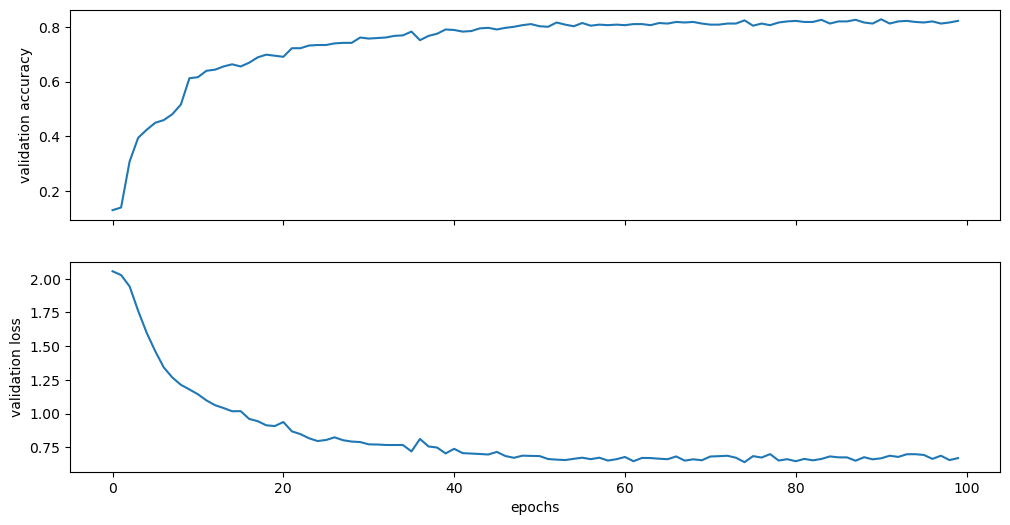

In [31]:
from maneuver_recognition import evaluation
evaluation.plot_training_process(loss_list, accuracy_list)

#### Evaluate model performance using a multi class correlation matrix with evaluation.confusion_heatmap
In order to evaluate the performance of our model, we can use the function predict() from the modelling module with our test data and then compare the predicted with the actual values. This can be done by first using our already created encoding object which inherits our label_encoder. The label_encoder enables the access to the previously encoded classes and features the function inverse_transform().

With these class labels and the inverse transformed y_test and y_pred data we can use the confusion_heatmap() function of the evaluation module to plot the comparison of actual and predicted values.
 
Since we have an unbalanced multi-class use case, and the color intensity of a regular heatmap takes all fields into account, the distribution should instead be inspected row by row which can be done by setting the parameter relative to True. In this way we can inspect each class separately for the amount of correctly classified values and get a True Positive rate for every single class in the diagonal.


In [32]:
y_pred = modelling.predict(X_test, model)

# Inverse transform the encoded y
y_test_inverse = encoding.label_encoder.inverse_transform(y_test)
y_pred_inverse = encoding.label_encoder.inverse_transform(y_pred)
classes = encoding.label_encoder.classes_

fig = evaluation.confusion_heatmap(y_test, y_pred, classes, relative=True)
fig.show()